# Looking at and random sampling from the 2D-encoded latent space.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import markers
from random import uniform, choice
import absl.logging
import os
absl.logging.set_verbosity(absl.logging.ERROR)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from keras import models

In [22]:
ptarr = np.load("saves/3d_points.npy", allow_pickle=True)

### Representations during training for each digit.
It would be nice if we could see in 4d the whole training process, but here are the representations at some discrete steps during the training. You can see the representative regions first find the origin then shrink, succumbing to regularization.

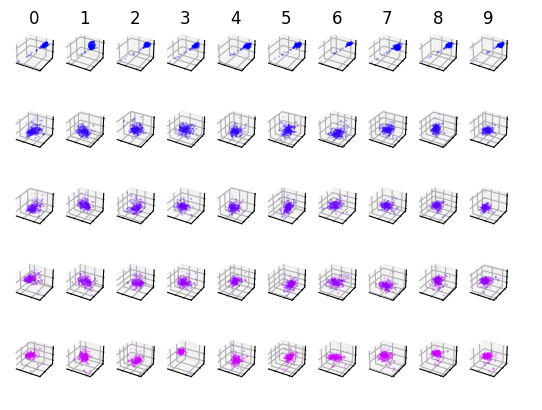

In [23]:
nsteps = 5
_, ax0 = plt.subplots(nsteps, 10, subplot_kw={"projection": "3d"})

for dig in range(10):
    for tp in range(nsteps):
        x, y, z = [ptarr[tp * len(ptarr) // nsteps][dig][i] for i in range(3)]
        ax0[tp, dig].set_xticklabels([])
        ax0[tp, dig].set_yticklabels([])
        ax0[tp, dig].set_zticklabels([])

        ax0[tp, dig].scatter3D(x, y, z, s=0.05, color=[(tp * len(ptarr) // nsteps) / len(ptarr), 0, 1])

        if tp == 0:
            ax0[tp, dig].title.set_text(dig)
plt.show()

### Final mapping regions for each digit

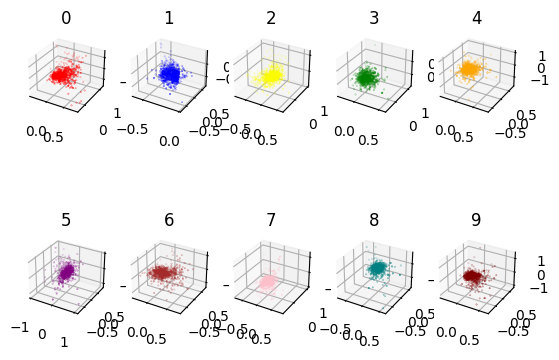

In [24]:
encoder3d = models.load_model("saved_models/encoder_3d", compile=False)

train_df = pd.read_csv("mnist/mnist_train.csv", header=None)
train_x = np.array(train_df.iloc[:, 1:].to_numpy().reshape((-1, 28, 28, 1)))
train_x = train_x/255.
train_y = np.array(train_df.iloc[:, 0].to_numpy().reshape((-1, 1)))

_, ax1 = plt.subplots(2, 5, subplot_kw={"projection": "3d"})
colors = ["red", "blue", "yellow", "green", "orange", "purple", "brown", "pink", "teal", "maroon"]
preds = {}
for dig in range(10):
    i, j = (dig - dig % 5) // 5, dig % 5
    dig_samp_xs, dig_samp_ys = [], []
    for _ in range(1000):
        ind = choice(range(len(train_x)))
        while train_y[ind].item() != dig:
            ind = choice(range(len(train_x)))

        dig_samp_xs.append(train_x[ind])
        dig_samp_ys.append(train_y[ind])

    dig_samp_xs = np.array(dig_samp_xs).reshape((-1, 28, 28, 1))
    dig_pred_ys = encoder3d.predict(dig_samp_xs, verbose=0)
    preds[dig] = dig_pred_ys

    x, y, z = [dig_pred_ys[:, k] for k in range(3)]
    ax1[i, j].scatter3D(x, y, z, s=0.05, color=colors[dig])
    ax1[i, j].title.set_text(dig)

plt.show()

### All final mappings on the same plot to get a sense of differentiation in class representations.
Here you can see even more drift than in the 2d representations, although all classes are still somewhat represented by the origin region. As the latent space grows in dimensions, the conditioning signal starts losing its decisiveness. Of course there are ways to strengthen this signal but it is some effort to find the balance with the two signals trying to dominate each other.

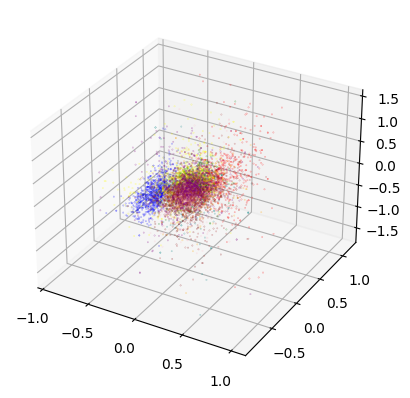

In [25]:
ax2 = plt.axes(projection="3d")
for dig in range(10):
    i, j = (dig - dig % 5) // 5, dig % 5
    x, y, z = [preds[dig][:, k] for k in range(3)]
    ax2.scatter3D(x, y, z, s=0.05, color=colors[dig], alpha=0.5)
plt.show()

### Random sampling by class
Generated outputs are quite good, although 1, which was stubborn in 2D, is even worse off now.

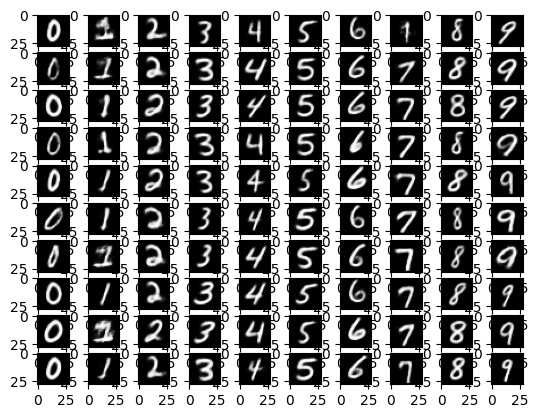

In [26]:
decoder3d = models.load_model("saved_models/decoder_3d", compile=False)

r = 0.2
_, ax3 = plt.subplots(10, 10)
for i in range(10):
    for j in range(10):
        hotcode = [0] * 10
        hotcode[j] = 1
        sample = np.array([[*[uniform(-r, r) for _ in range(3)], *hotcode]])
        pred = decoder3d.predict(sample, verbose=0)[0]
        ax3[i, j].imshow(pred, cmap="gray")
plt.show()
